In [1]:
import sys

print(sys.version)  # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm, Colormap, Normalize
import matplotlib.patches as patches

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

from itertools import combinations, combinations_with_replacement

In [3]:
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))

In [4]:
df = pd.read_csv("/data/fp_ica.csv")
df = df.set_index("ID")
df[:5].T

ID,2829_105,999_37,7770_55A,2140_92B,509_73
Unnamed: 0,0,1,2,3,4
true_year,0.520,0.360,0.200,0.520,0.500
prediction,0.564,0.407,0.392,0.500,0.486
row,0,1,2,3,4
factor0,0.611,-2.766,-4.549,-0.829,-0.539
factor1,1.785,-0.138,0.465,1.609,1.325
factor2,-0.388,-0.335,1.008,0.456,-0.499
factor3,-0.324,0.763,-0.274,-0.606,0.784
factor4,0.403,0.294,-0.669,-0.178,0.302
factor5,-0.914,1.408,-0.723,0.384,-0.240


In [5]:
df_pixel = pd.read_csv("/data/fp_pixel.csv")
df_pixel = df_pixel.set_index("ID")
df = df.join(df_pixel)

In [6]:
def plot_hexbin_equal(
    x,
    y,
    C=None,
    reduce_C_function=np.mean,
    bins=None,
    xlabel=None,
    ylabel=None,
    gridscale=None,
    n_grid=400,
    mincnt=10,
    cmap="viridis",
    norm=None,
    vmin=None,
    vmax=None,
    ax=None,
    figsize=(11, 15),
):
    if xlabel is None:
        xlabel = x.name
    if ylabel is None:
        ylabel = y.name

    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=300)
        ax = fig.gca()

    if C is not None:
        if vmin is None:
            vmin = np.amin(C)
        if vmax is None:
            vmax = np.amax(C)

    xlim, ylim = (np.quantile(a, (0.005, 0.995)) for a in [x, y])
    if gridscale is None:
        gridscale = sqrt((xlim[1] - xlim[0]) * (ylim[1] - ylim[0]) / n_grid)
    gridsize = (
        int((xlim[1] - xlim[0]) / gridscale),
        int((ylim[1] - ylim[0]) / (gridscale * sqrt(3))),
    )
    poly = ax.hexbin(
        x,
        y,
        C,
        reduce_C_function=reduce_C_function,
        gridsize=gridsize,
        bins=bins,
        extent=(*xlim, *ylim),
        mincnt=mincnt,
        cmap=cmap,
        norm=norm,
        vmin=vmin,
        vmax=vmax,
    )

    #     plt.colorbar(poly, ax=ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect("equal")

    return poly

In [7]:
def plot_hexbin_aspect(
    x,
    y,
    C=None,
    reduce_C_function=np.mean,
    bins=None,
    xlabel=None,
    ylabel=None,
    n_grid=400,
    mincnt=10,
    cmap="viridis",
    norm=None,
    xlim=None,
    ylim=None,
    vmin=None,
    vmax=None,
    ax=None,
    figsize=(11, 15),
    aspect=1,
):
    if xlabel is None:
        xlabel = x.name
    if ylabel is None:
        ylabel = y.name

    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=300)
        ax = fig.gca()

    if C is not None:
        if vmin is None:
            vmin = np.amin(C)
        if vmax is None:
            vmax = np.amax(C)

    if xlim is None:
        xlim = np.quantile(x, (0.005, 0.995))
    if ylim is None:
        ylim = np.quantile(y, (0.005, 0.995))

    gridscale = sqrt((xlim[1] - xlim[0]) * (ylim[1] - ylim[0]) / n_grid)

    gridsize = (
        int((xlim[1] - xlim[0]) / gridscale / sqrt(aspect)),
        int((ylim[1] - ylim[0]) / (gridscale * sqrt(3)) * sqrt(aspect)),
    )
    poly = ax.hexbin(
        x,
        y,
        C,
        reduce_C_function=reduce_C_function,
        gridsize=gridsize,
        bins=bins,
        extent=(*xlim, *ylim),
        mincnt=mincnt,
        cmap=cmap,
        norm=norm,
        vmin=vmin,
        vmax=vmax,
    )

    #     plt.colorbar(poly, ax=ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #     ax.set_aspect(aspect)

    return poly

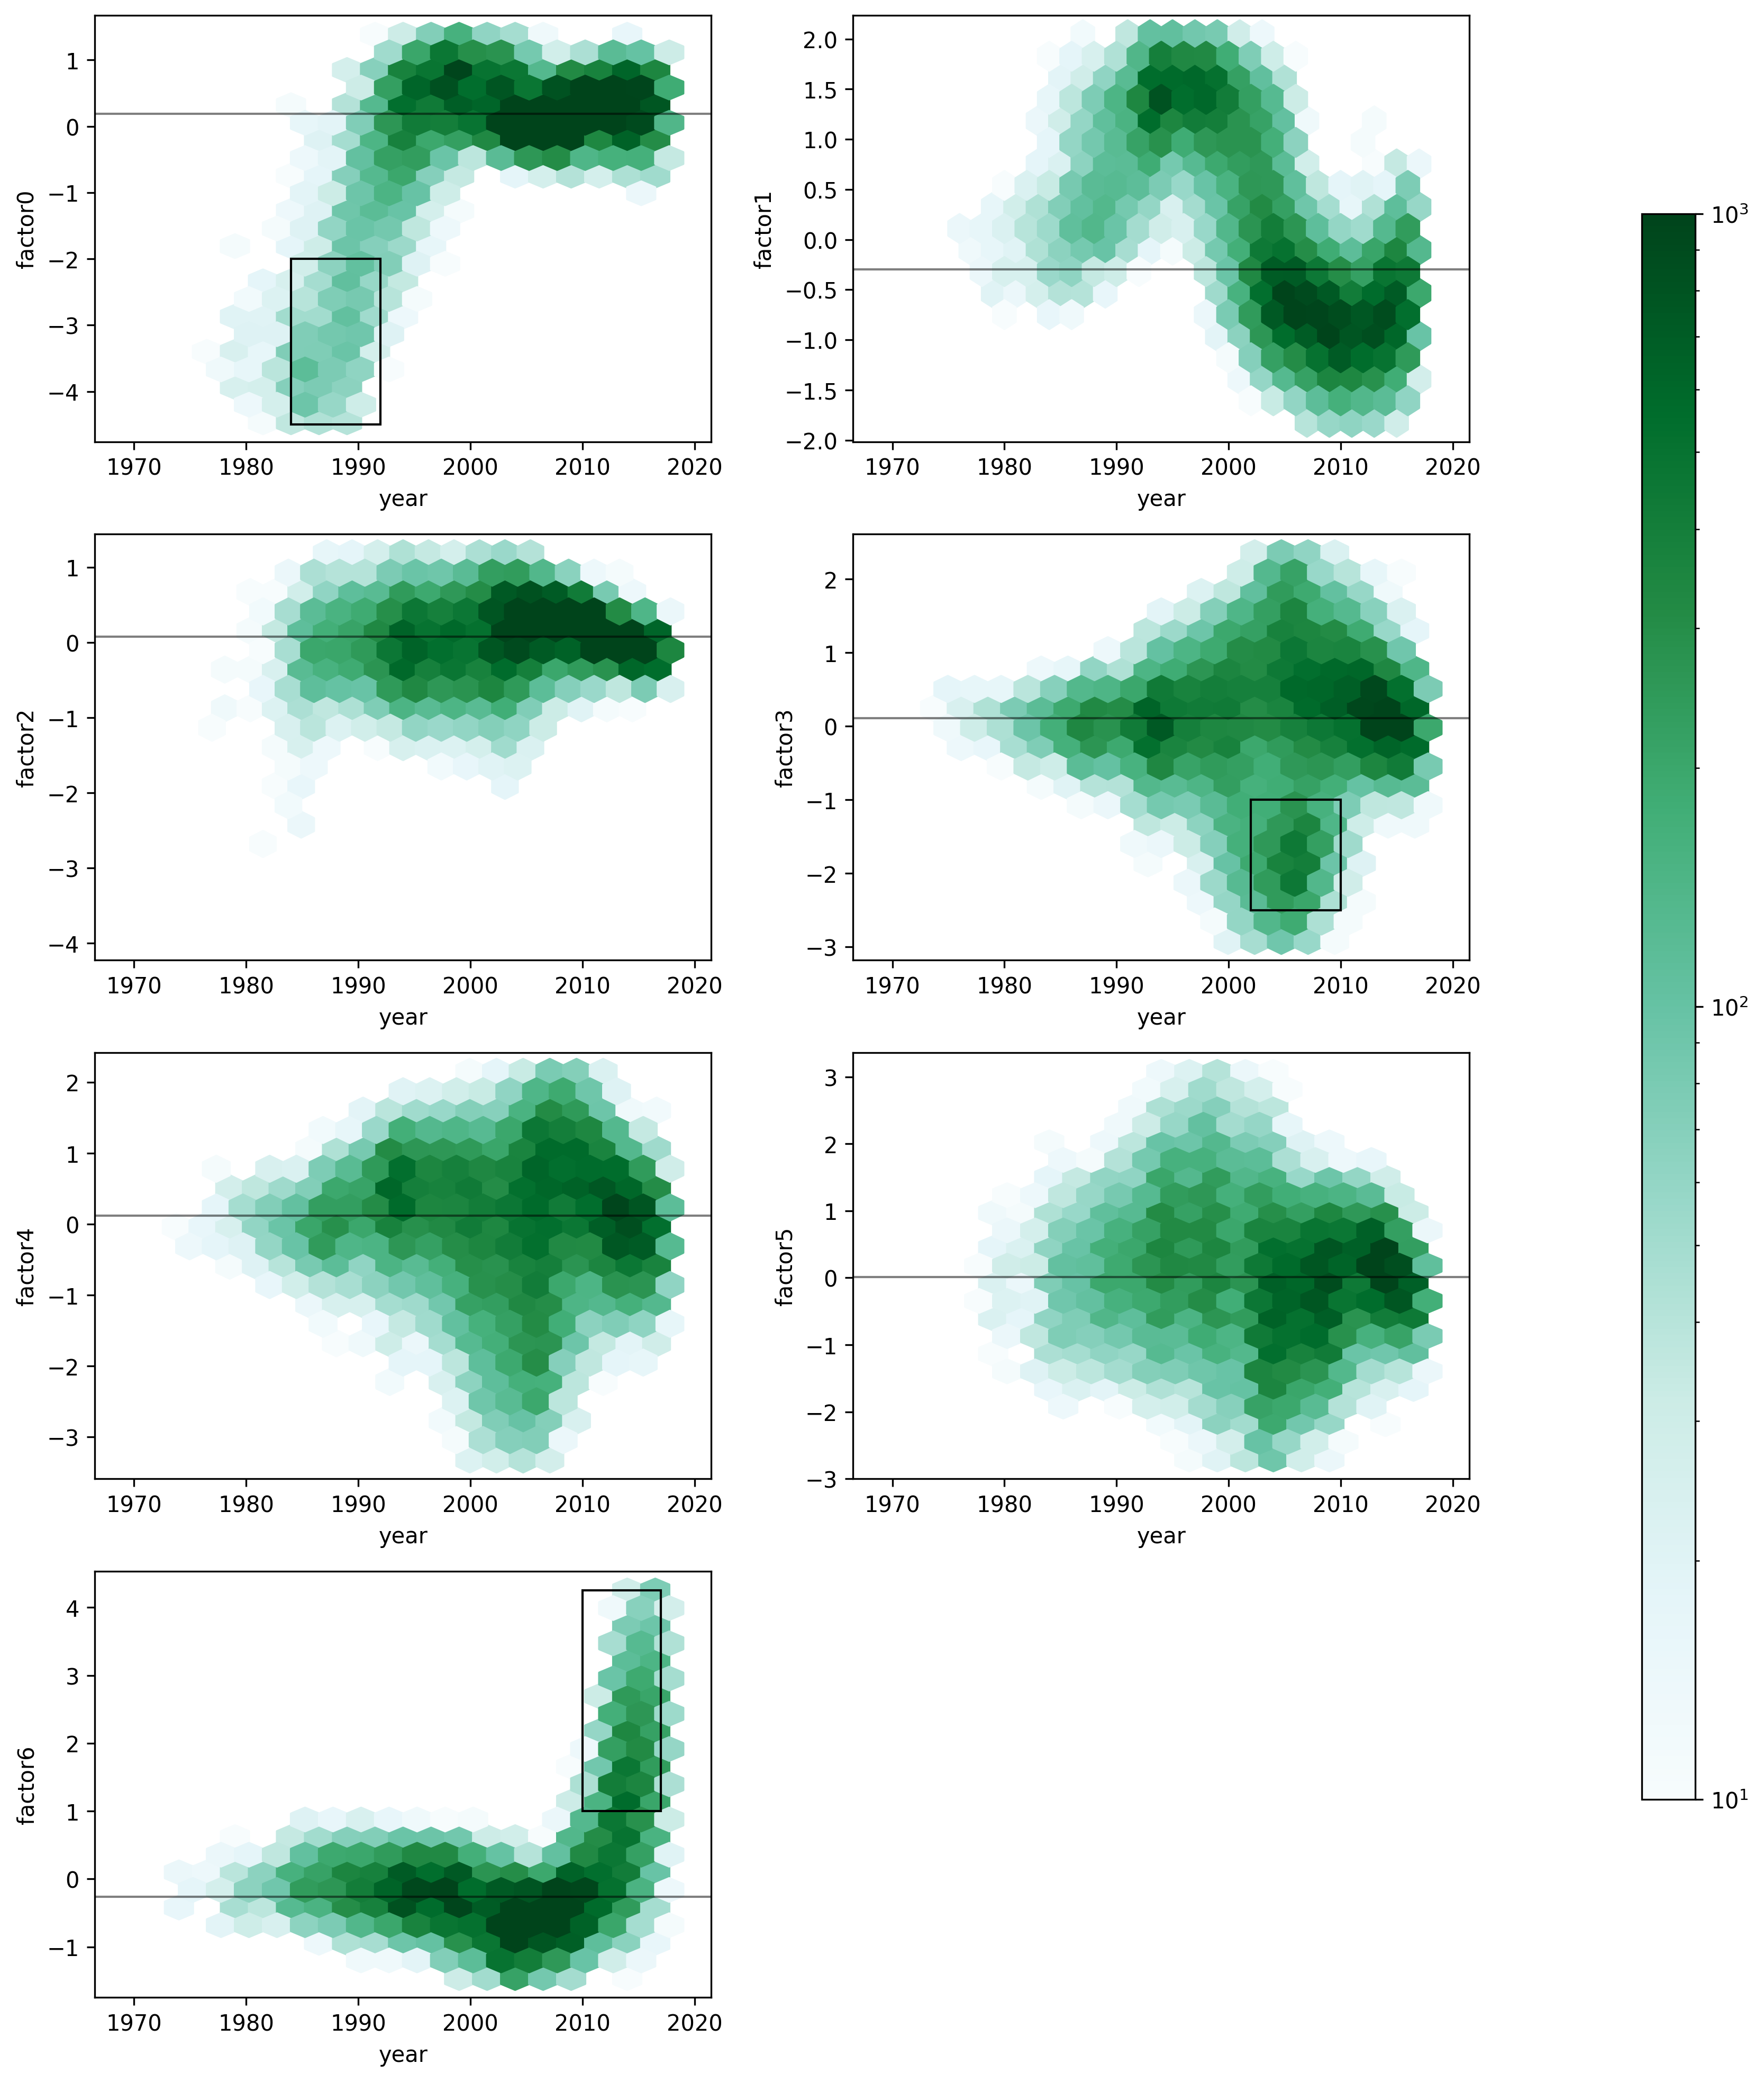

In [16]:
lims = [np.quantile(df[f], (0.005, 0.995)) for f in [f"factor{i}" for i in range(7)]]
diffs = [np.diff(lims[i])[0] for i in range(7)]

fig = plt.figure(figsize=(11, 13), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(4, 2)

axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(7)]

plots = [(axes[i], "year", f"factor{i}") for i in range(7)]

for ax, x, y in plots:
    plot_hexbin_aspect(
        df[x],
        df[y],
        cmap="BuGn",
        bins="log",
        vmax=1000,
        xlim=[1969, 2019],
        mincnt=10,
        ax=ax,
        n_grid=400,
        aspect=8,
    )
    ax.axhline(df[y].median(), lw=1, c="k", alpha=0.5)

axes[0].add_patch(
    patches.Rectangle((1984, -4.5), 8, 2.5, fill=False)
)  # 1982 <= year <= 1996 and -4.5 <= factor3 <= -1.0

axes[3].add_patch(
    patches.Rectangle((2002, -2.5), 8, 1.5, fill=False)
)  # 2002 <= year <= 2010 and -2.5 <= factor3 <= -1.0

axes[6].add_patch(
    patches.Rectangle((2010, 1), 7, 3.25, fill=False)
)  # 2010 <= year <= 2018 and 1.0 <= factor6 <= 4.25

fig.colorbar(axes[0].collections[0], ax=[ax for ax, _, _ in plots], pad=0.1, shrink=0.8)
fig.savefig("ICA_year_hexbin.pdf", bbox_inches="tight", pad_inches=0)

In [10]:
df["cluster"]=-1

df.loc[df.eval("1984 <= year <= 1992 and -4.5 <= factor0 <= -2.0"), "cluster"] = 0
df.loc[df.eval("2002 <= year <= 2010 and -2.5 <= factor3 <= -1.0"), "cluster"] = 3
df.loc[df.eval("2010 <= year <= 2017 and 1.0 <= factor6 <= 4.25"), "cluster"] = 6

In [11]:
df["cluster"].value_counts()

-1    37392
 6     5976
 3     5010
 0     2162
Name: cluster, dtype: int64

In [12]:
df.loc[df["cluster"]>=0]["cluster"].unique()

array([0, 3, 6])

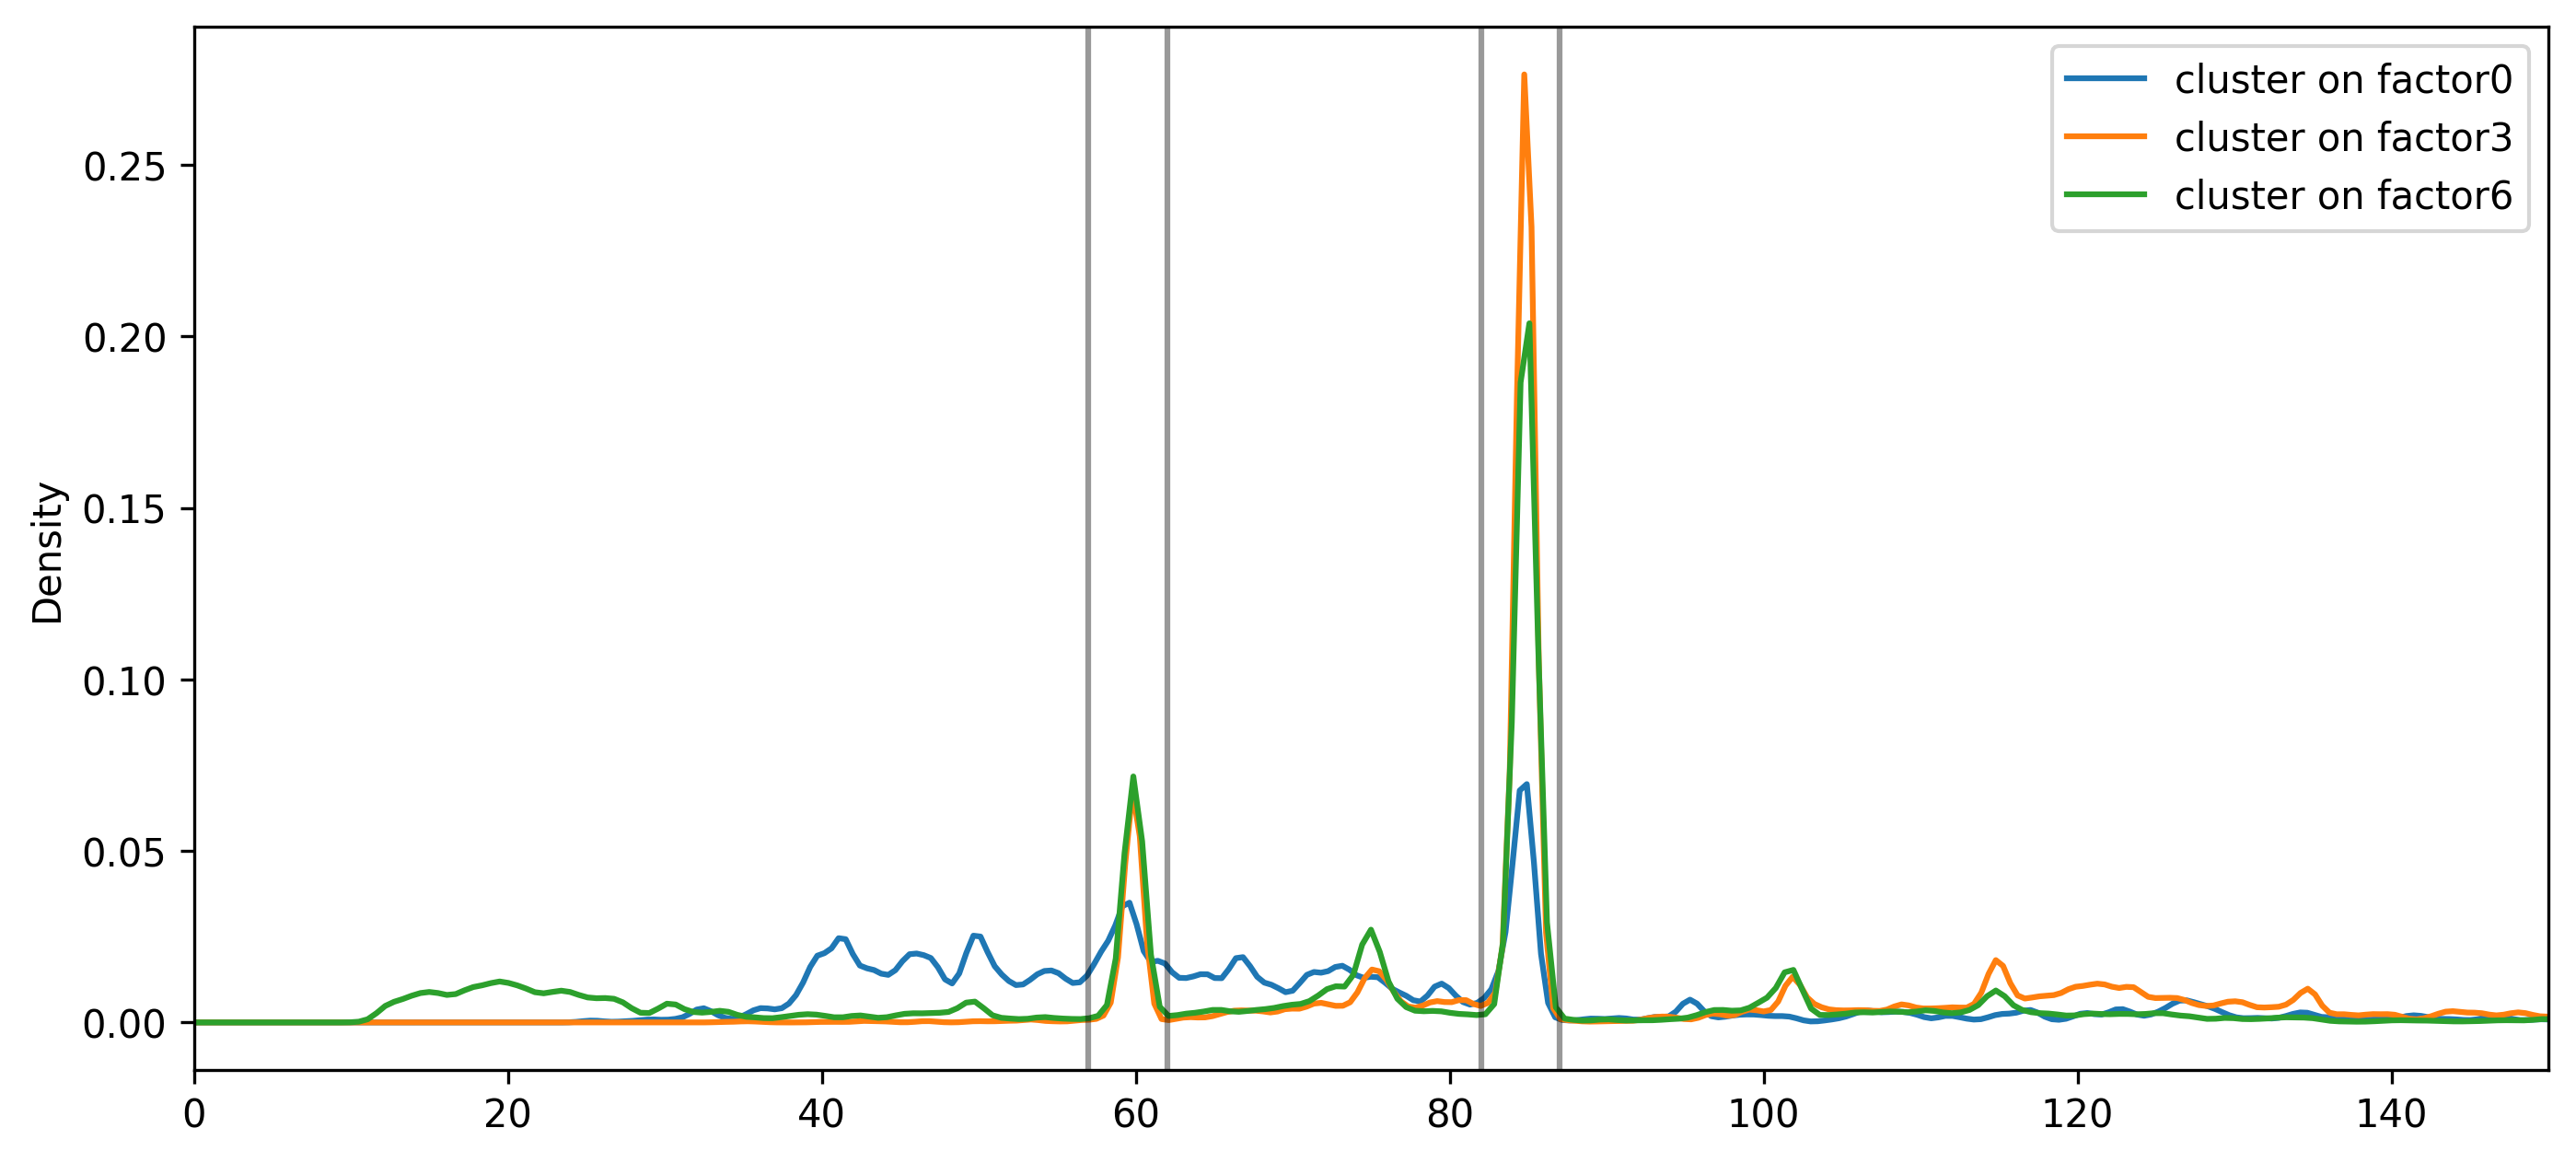

In [13]:
fig = plt.figure(figsize=(11, 5), dpi=300)
df.loc[df["cluster"] >= 0].groupby("cluster")["Area"].plot.kde(
    xlim=(0, 150), bw_method=0.02
)

plt.legend(["cluster on factor"+a.get_label() for a in fig.gca().get_lines()])

plt.axvline(57, c="k", alpha=0.4)
plt.axvline(62, c="k", alpha=0.4)
plt.axvline(82, c="k", alpha=0.4)
plt.axvline(87, c="k", alpha=0.4)

fig.savefig("cluster_area_kde.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("cluster_area_kde.png", bbox_inches="tight", pad_inches=0)